## PUNTO 1


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn import metrics
import warnings
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('src\weatherAUS.csv', sep = ',')

In [4]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


## Division del conjunto de datos ##

In [5]:
# Definir X e y
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [6]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Datos faltantes ###

In [7]:
df.isnull().sum()


Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Podemos ver que en todas las columnas hay datos faltantes.


Primero vemos que no haya columnas duplicadas.


In [8]:
X_train.duplicated().sum()

np.int64(0)

## Imputación de datos faltantes ##


Los valores nulos tendremos que tratarlos de columna en columna

#### MinTemp  y MaxTemp ####

In [9]:
df['MinTemp'].fillna(df['MinTemp'].mean(), inplace=True)
df['MaxTemp'].fillna(df['MaxTemp'].mean(), inplace=True)

Se eligio reemplazar los valores nulos por la media ya que la distribución no es muy asimetrica.


#### Rainfall ####


In [10]:
# Rainfall: Usar la mediana (menos sensible a valores extremos)
df['Rainfall'].fillna(df['Rainfall'].median(), inplace=True)

Se eligio reemplazar los valores nulos por la mediana ya que es menos sensible a valores extremos.


#### Evaporation y Sunshine ####


In [11]:
df['Evaporation'].fillna(df['Evaporation'].mean(), inplace=True)
df['Sunshine'].fillna(df['Sunshine'].mean(), inplace=True)

Aunque pueden tener cierta asimetría, la media sigue siendo una buena estimación del valor típico. Tambien porque la evaporación y las horas de sol suelen tener una variación más gradual que la lluvia.


#### WindGustDir, WindDir9am y WindDir3pm ####



In [12]:
df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)

Se eligio reemplazar los valores nulos por la moda ya que la moda representa la dirección del viento más común, que es una buena estimación para valores faltantes.

#### WindGustSpeed y WindSpeed9am, WindSpeed3pm ####

In [13]:
df['WindGustSpeed'].fillna(df['WindGustSpeed'].median(), inplace=True)
df['WindSpeed9am'].fillna(df['WindSpeed9am'].median(), inplace=True)
df['WindSpeed3pm'].fillna(df['WindSpeed3pm'].median(), inplace=True)

Se eligio reeemplazar por la mediana ya que la velocidad del viento puede tener una distribución sesgada, similar a la lluvia. Y la mediana es menos afectada por valores extremos ocasionales de vientos fuertes.

#### Humidity9am y Humidity3pm ####


In [14]:
df['Humidity9am'].fillna(df['Humidity9am'].mean(), inplace=True)
df['Humidity3pm'].fillna(df['Humidity3pm'].mean(), inplace=True)

Se eligio reemplazar por la media ya que la humedad suele tener una distribución más simétrica que la lluvia o el viento. Y la media proporciona una buena estimación del nivel de humedad típico.


#### Pressure9am y Pressure3pm ####

In [15]:
df['Pressure9am'].fillna(df['Pressure9am'].mean(), inplace=True)
df['Pressure3pm'].fillna(df['Pressure3pm'].mean(), inplace=True)

Se eligio reemplazar por la media porque la presión atmosférica tiende a tener una distribución bastante simétrica y los cambios en la presión suelen ser graduales, haciendo de la media una buena representación.


#### Cloud9am y Cloud3pm ####


In [16]:
df['Cloud9am'].fillna(df['Cloud9am'].median(), inplace=True)
df['Cloud3pm'].fillna(df['Cloud3pm'].median(), inplace=True)

Se eligio reemplazar por la mediana pues la nubosidad se mide en una escala discreta (octavos), y la mediana proporciona un valor central que es un número entero en la escala de nubosidad. 

#### Temp9am y Temp3pm ####


In [17]:
df['Temp9am'].fillna(df['Temp9am'].mean(), inplace=True)
df['Temp3pm'].fillna(df['Temp3pm'].mean(), inplace=True)

Se eligio reemplazar por la media pues, similarmente a MinTemp y MaxTemp, las temperaturas suelen seguir una distribución aproximadamente normal.

#### RainToday ####


In [18]:
df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)

Se eligio la reemplazar por la moda porque es una variable categórica binaria (Sí/No), y la moda representa el resultado más frecuente, que es una buena estimación para un evento binario.

#### RainTomorrow ####


In [19]:
df.dropna(subset=['RainTomorrow'], inplace=True)

Se decidio eliminar las filas con valores nulos pues es la variable objetivo que queremos predecir, y el imputar valores en la variable objetivo podría introducir sesgos significativos en el modelo.

Verificamos que ya no haya valores nulos.

In [20]:
print(df.isnull().sum())

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


## Visualización de datos ##

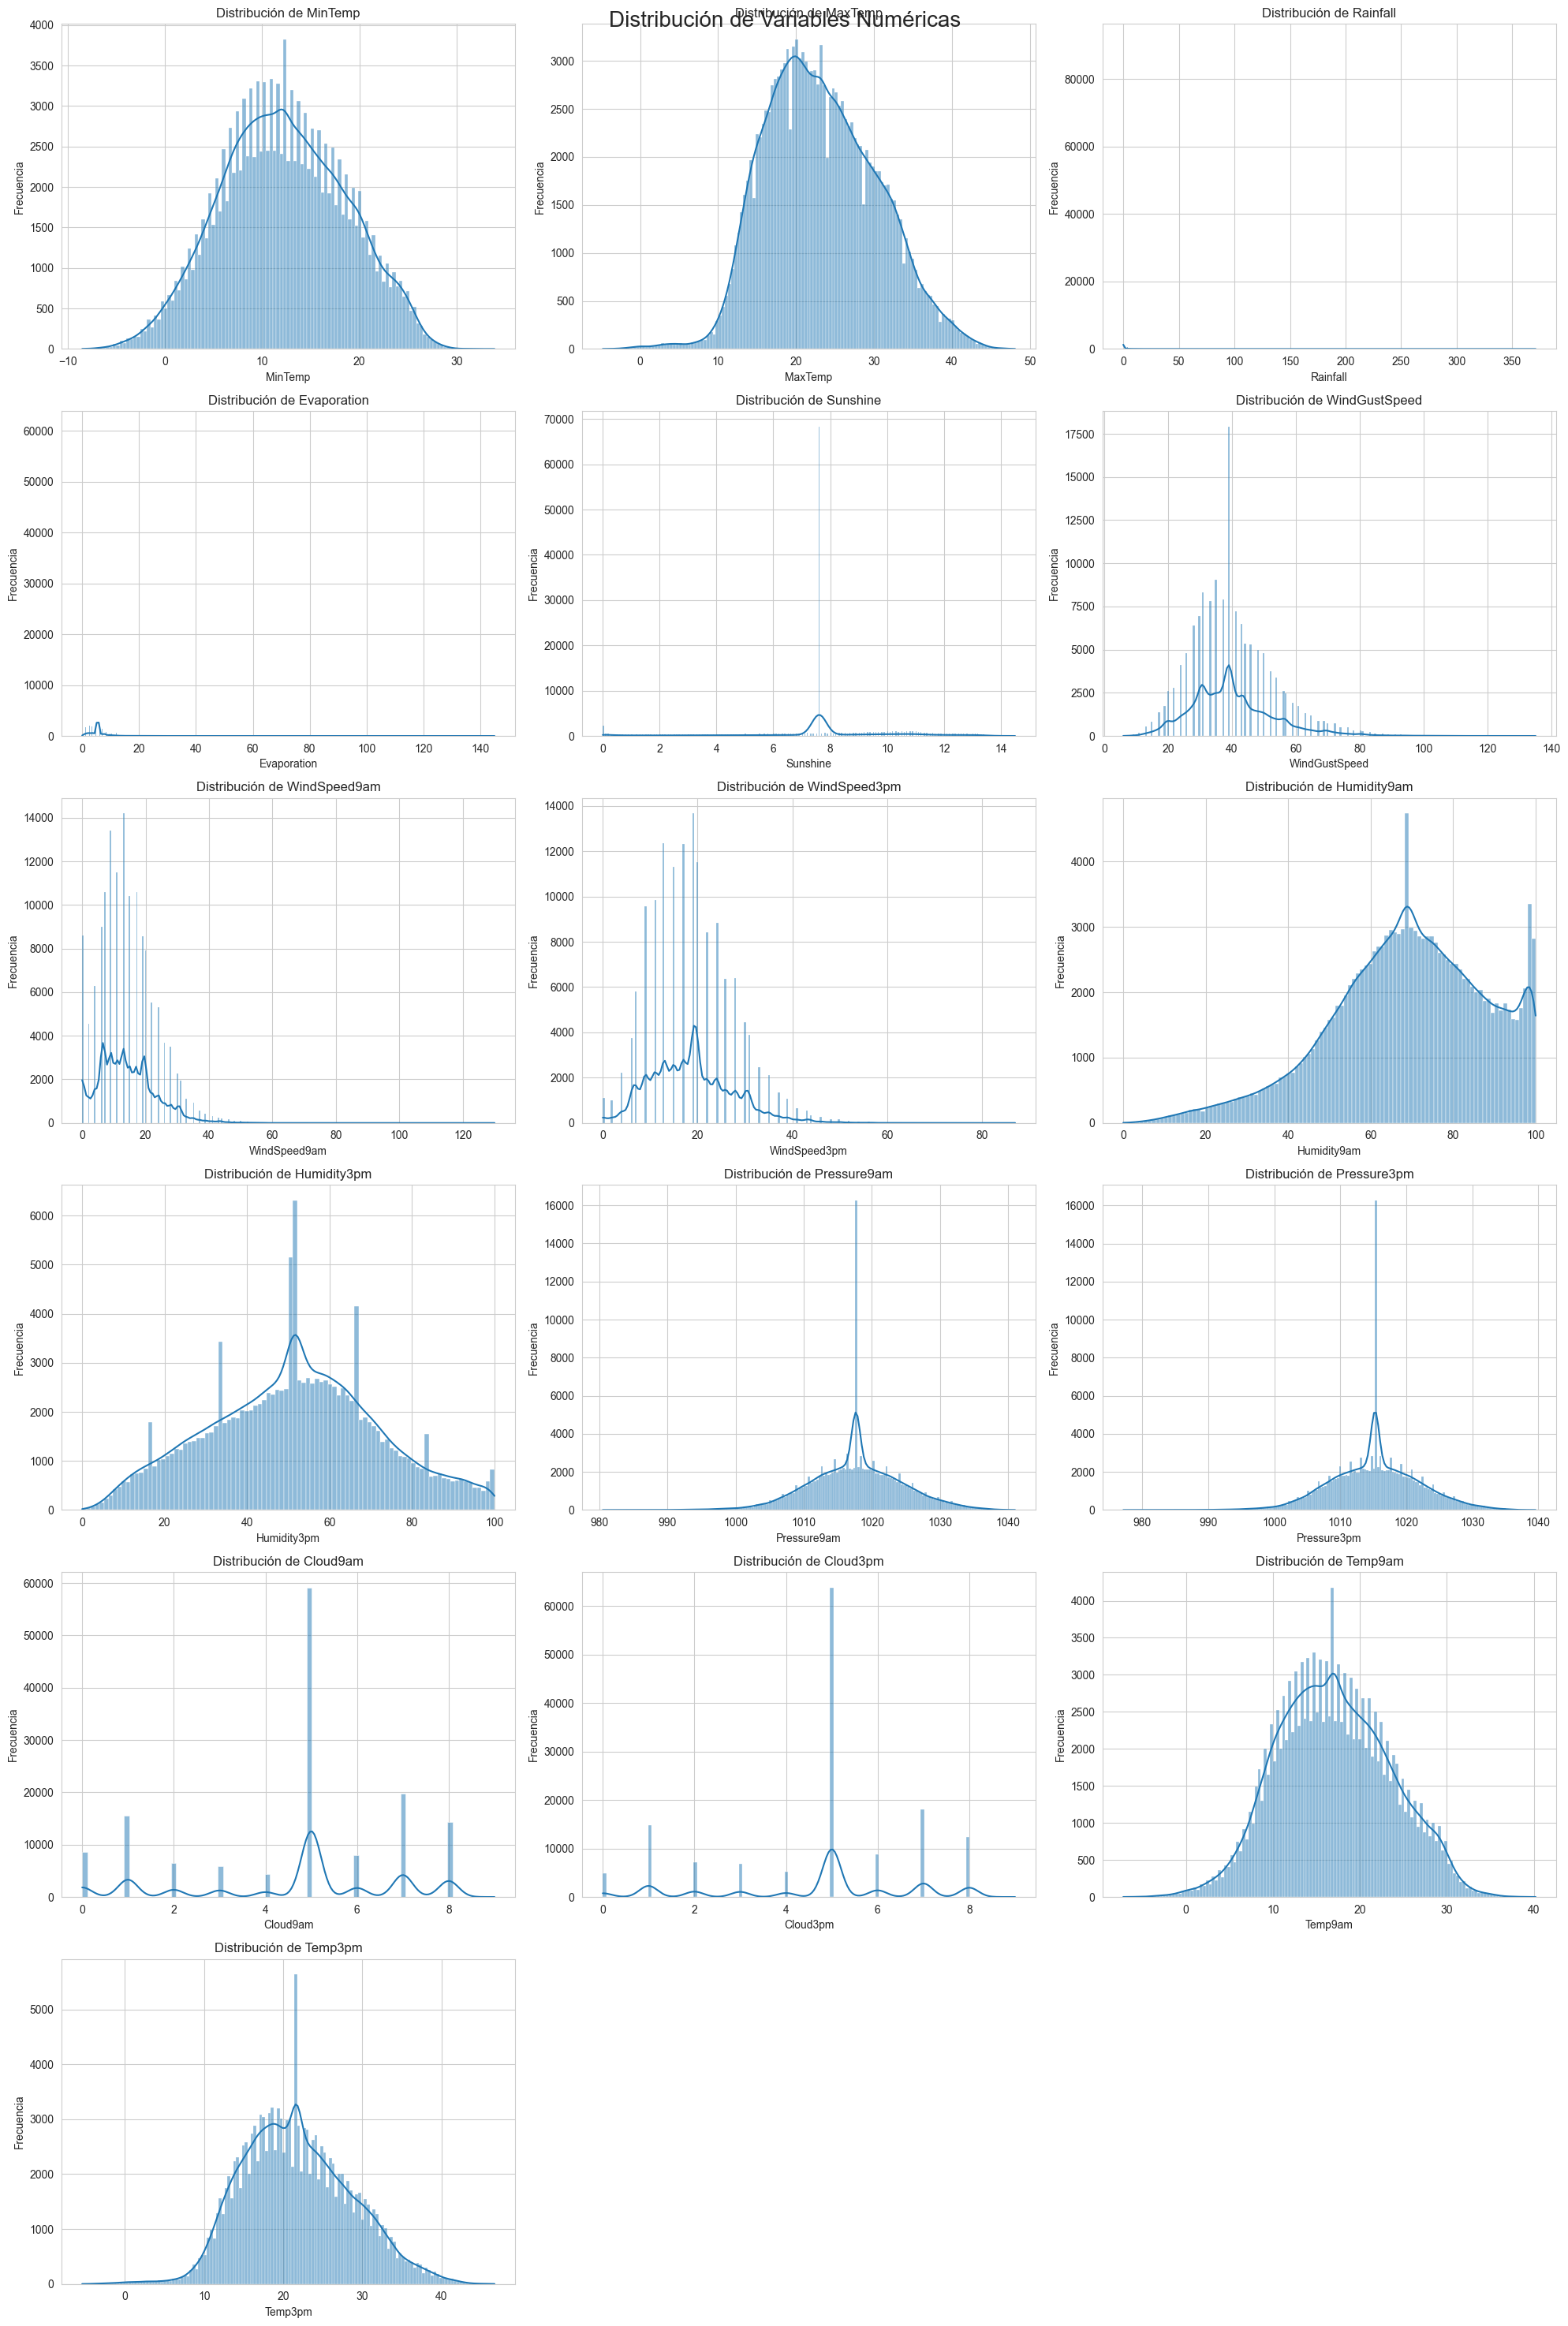

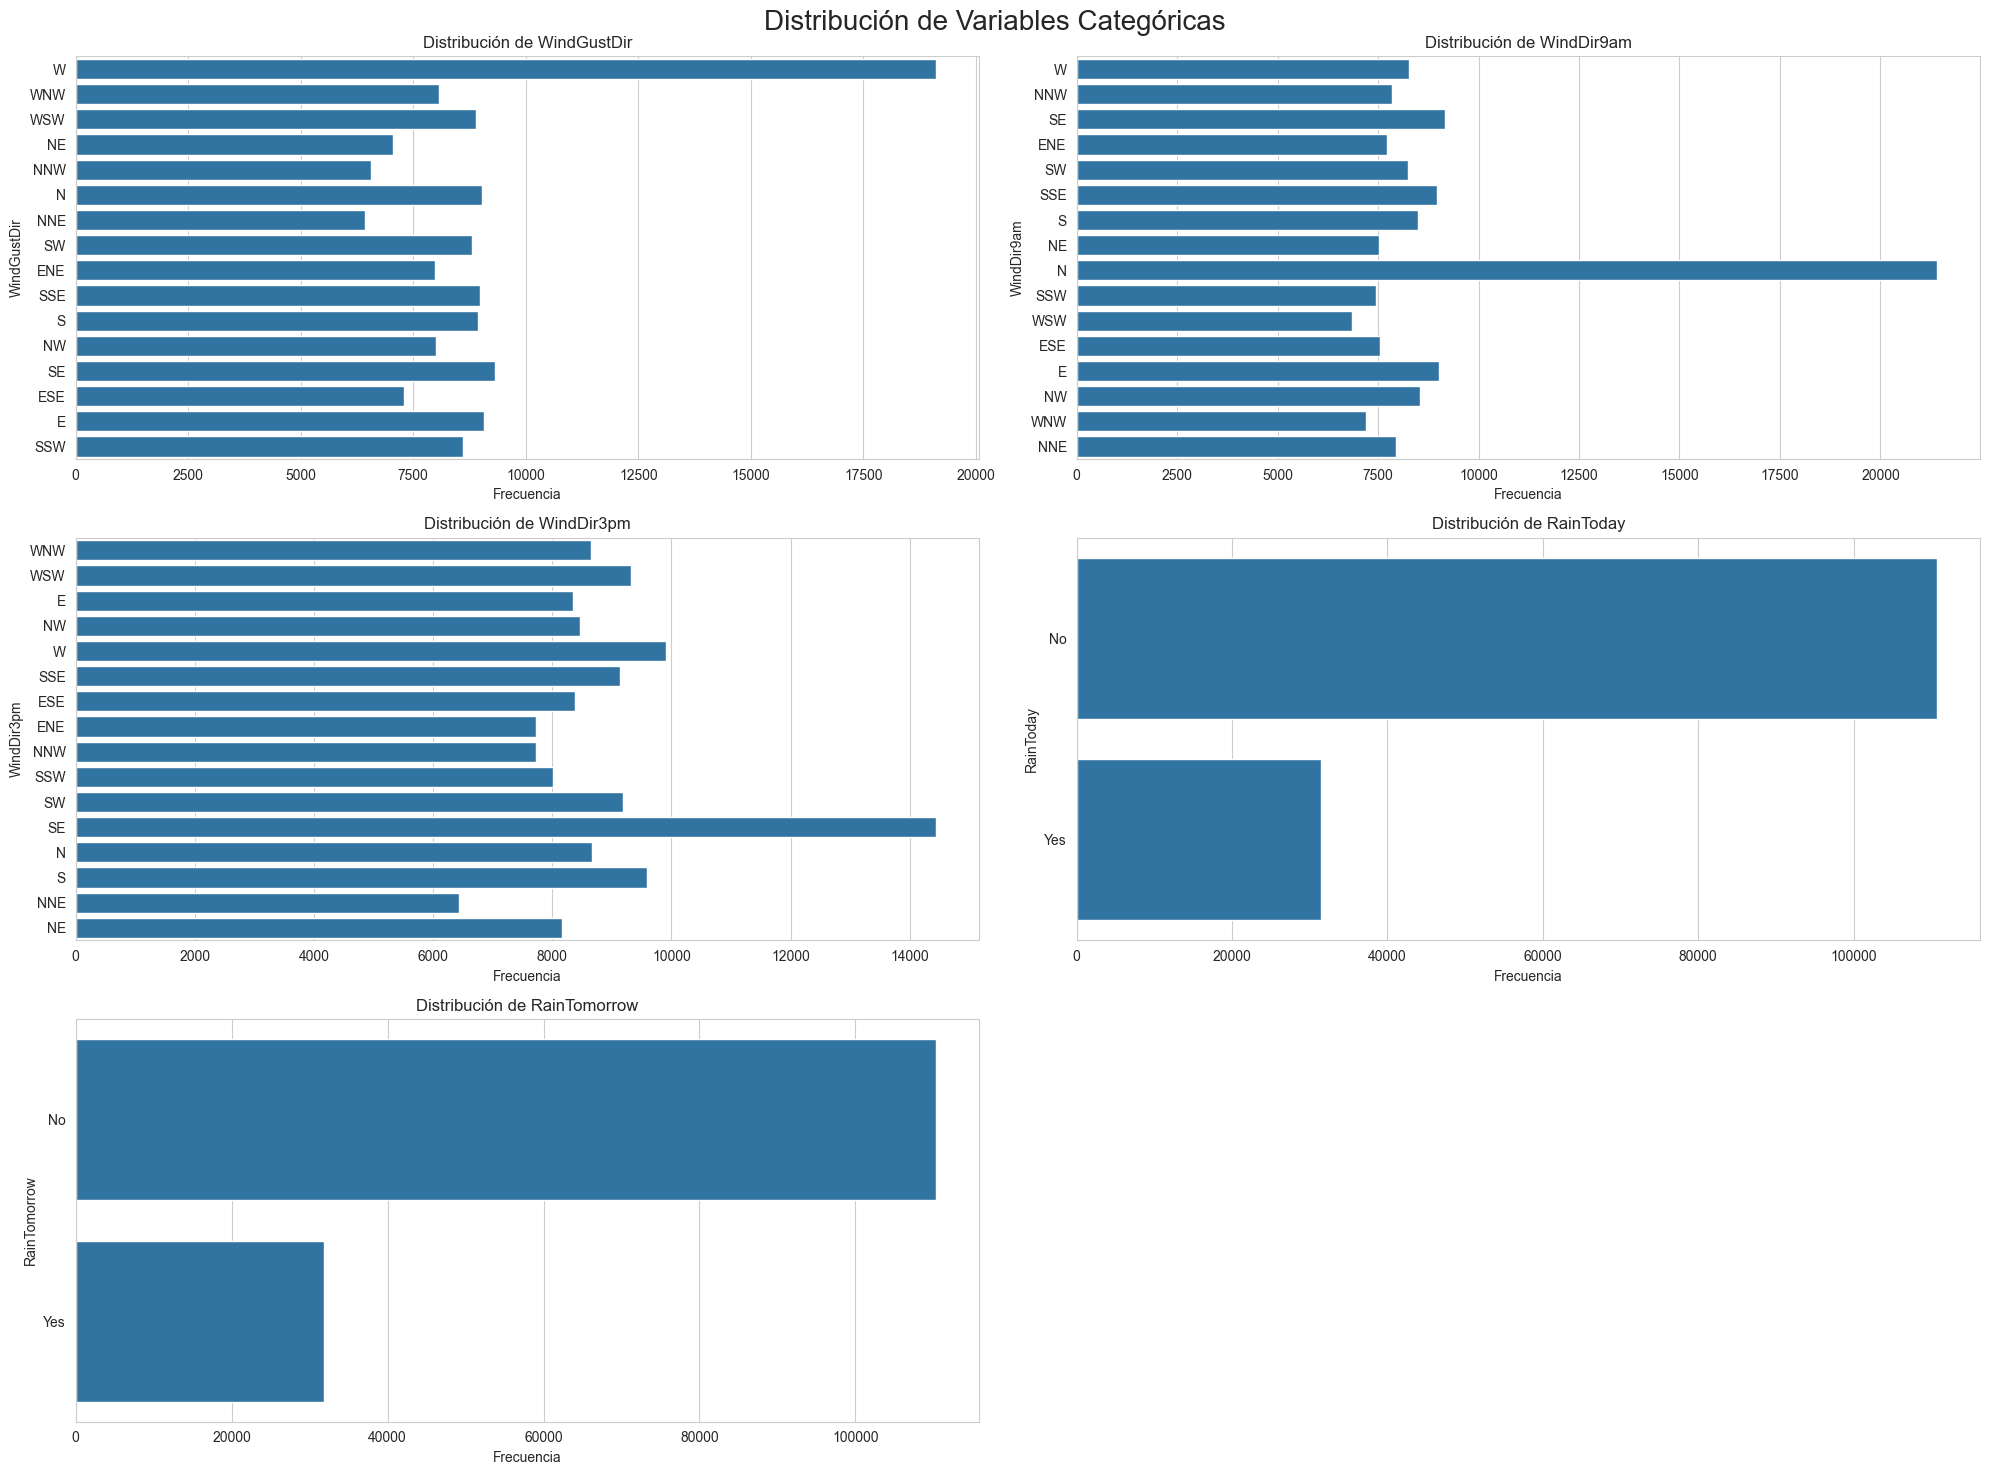

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Asumiendo que tu DataFrame se llama 'df'

# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar el estilo de seaborn
sns.set_style("whitegrid")

# Calcular el número de filas y columnas para el subplot
n_cols = 3  # Puedes ajustar esto según prefieras
n_rows = math.ceil(len(numeric_columns) / n_cols)

# Crear la figura y los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Distribución de Variables Numéricas', fontsize=20)

# Aplanar el array de axes si es necesario
axes = axes.flatten() if n_rows > 1 else [axes]

# Crear un histograma para cada variable numérica
for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Frecuencia', fontsize=10)

# Ocultar subplots vacíos
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Para variables categóricas, excluyendo 'Date' y 'Location'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in ['Date', 'Location']]

# Calcular el número de filas y columnas para el subplot de variables categóricas
n_cols_cat = 2  # Puedes ajustar esto según prefieras
n_rows_cat = math.ceil(len(categorical_columns) / n_cols_cat)

# Crear la figura y los subplots para variables categóricas
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5*n_rows_cat))
fig.suptitle('Distribución de Variables Categóricas', fontsize=20)

# Aplanar el array de axes si es necesario
axes = axes.flatten() if n_rows_cat > 1 else [axes]

# Crear un gráfico de barras para cada variable categórica
for i, column in enumerate(categorical_columns):
    sns.countplot(y=column, data=df, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel('Frecuencia', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)

# Ocultar subplots vacíos
for i in range(len(categorical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

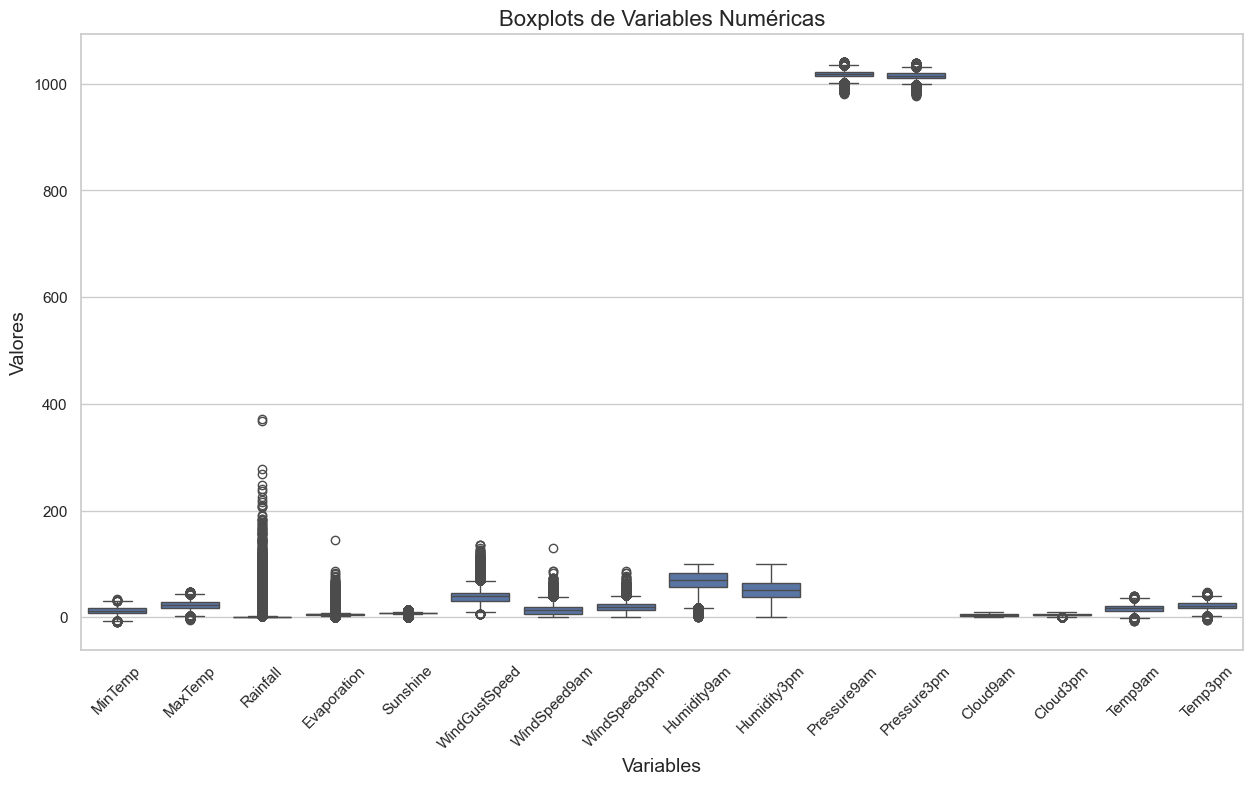

In [22]:
# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Transformar el DataFrame a formato largo
df_melted = pd.melt(df, value_vars=numeric_columns)

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear boxplots para todas las columnas numéricas en un solo gráfico
plt.figure(figsize=(15, 8))
sns.boxplot(x='variable', y='value', data=df_melted)
plt.title('Boxplots de Variables Numéricas', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

### Descripcion de variables ###

1. MinTemp: Al ser la temperatura mínima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, ligeramente sesgada a la izquierda. La moda parece estar alrededor de los 10-15°C. Aunque no tenemos un boxplot, es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o cálidos.
2. MaxTemp: Al ser la temperatura máxima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, posiblemente con un ligero sesgo a la derecha. La moda parece estar alrededor de los 20-25°C. Es probable que haya valores atípicos en el extremo superior, representando días excepcionalmente calurosos.
3. Rainfall: Al ser la cantidad de lluvia registrada en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución fuertemente sesgada a la derecha, con una moda muy pronunciada en o cerca de 0 mm. La distribución tiene una cola larga hacia la derecha, indicando días ocasionales de lluvia intensa. Es muy probable que haya numerosos valores atípicos en el extremo superior de la distribución.
4. Evaporation: Al ser la evaporación en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores concentrados en el rango inferior. La moda parece estar cerca de 2-4 mm. Es probable que haya valores atípicos en el extremo superior, representando días con evaporación excepcionalmente alta.
5. Sunshine: Al ser el número de horas de sol brillante en el día, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución que podría ser bimodal o uniforme, reflejando la variación estacional en las horas de luz diurna. La distribución probablemente abarca desde 0 hasta 12-14 horas, con picos que podrían corresponder a los patrones de invierno y verano.
6. WindGustSpeed: Al ser la velocidad de la ráfaga de viento más fuerte en las últimas 24 horas (km/h), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores en el rango bajo a medio. La moda parece estar alrededor de 30-40 km/h. Es probable que haya valores atípicos en el extremo superior, representando ráfagas de viento excepcionalmente fuertes.
7. WindSpeed9am y WindSpeed3pm: Al ser la velocidad del viento a las 9 am y 3 pm respectivamente (km/h), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones sesgadas a la derecha, similares a WindGustSpeed pero con valores generalmente más bajos. Las modas probablemente están en el rango de 10-20 km/h. Es probable que haya valores atípicos en los extremos superiores.
8. Humidity9am y Humidity3pm: Al ser el porcentaje de humedad a las 9 am y 3 pm respectivamente, podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones que podrían ser bimodales o uniformes, abarcando un rango amplio de valores. Las modas podrían estar alrededor del 60-70% y 40-50% respectivamente. Es menos probable que haya valores atípicos extremos debido a la naturaleza limitada de la escala de porcentaje.
9. Pressure9am y Pressure3pm: Al ser la presión atmosférica a las 9 am y 3 pm respectivamente (hpa), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, centradas alrededor de 1010-1020 hpa. La variación es relativamente pequeña, reflejando la estabilidad general de la presión atmosférica. Es posible que haya algunos valores atípicos en ambos extremos, representando condiciones atmosféricas inusuales.
10. Cloud9am y Cloud3pm: Al ser la fracción de cielo cubierto por nubes a las 9 am y 3 pm respectivamente (octavos), podemos observar que son variables cuantitativas discretas. Las distribuciones probablemente muestran picos en valores específicos (0, 4, 8 octavos), reflejando la naturaleza discreta de la medición. Podría haber una ligera tendencia hacia valores más altos o más bajos dependiendo del clima local.
11. Temp9am y Temp3pm: Al ser la temperatura a las 9 am y 3 pm respectivamente (°C), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, con Temp3pm generalmente más alta y posiblemente con mayor varianza que Temp9am. Las modas probablemente están alrededor de 15-20°C para Temp9am y 20-25°C para Temp3pm. Es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o calurosos.
12. RainToday y RainTomorrow: Al ser variables categóricas binarias (Sí/No) que indican si llovió hoy o si lloverá mañana, podemos observar que son variables cualitativas nominales. La distribución muestra dos barras, una para 'Sí' y otra para 'No'. Es probable que la barra de 'No' sea significativamente más alta, indicando que los días sin lluvia son más comunes que los días con lluvia.

## Balance del modelo ##

RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64


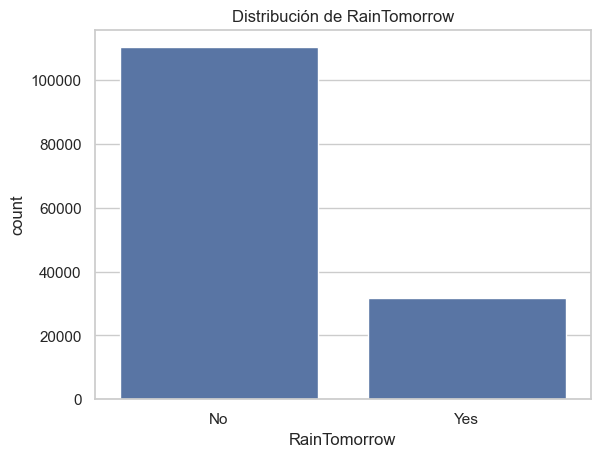

In [23]:
# Verificar el balance de la variable objetivo (RainTomorrow)
print(df['RainTomorrow'].value_counts(normalize=True))

# Visualizar el balance
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

Gracias al grafico, podemos ver que el dataset no esta balanceado, pues hay mas valores de que no va a llover, que de que si. Creemos que se hace esta pregunta para poder ver posibles problemas a futuro, como el impacto que tiene esto en el modelo.

## Codificacion de variables ##

Usamos one hot enoding porque

In [24]:
# Identificar las columnas categóricas que realmente están en el DataFrame
all_columns = df.columns.tolist()
cat_columns = [col for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 
               if col in all_columns]

print("Columnas categóricas encontradas:", cat_columns)

if y is None:
    print("Advertencia: 'RainTomorrow' no se encuentra en el DataFrame. Verifica tus datos.")
    # Aquí podrías decidir detener la ejecución o manejar este caso de alguna otra manera

# One-hot encoding para las variables categóricas en X
cat_columns_X = [col for col in cat_columns if col != 'RainTomorrow']
onehot_X = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar solo en los datos de entrenamiento
X_cat_encoded_train = onehot_X.fit_transform(X_train[cat_columns_X])
X_cat_encoded_test = onehot_X.transform(X_test[cat_columns_X])

# Crear DataFrames con las nuevas columnas codificadas
X_cat_encoded_train_df = pd.DataFrame(X_cat_encoded_train, 
                                      columns=onehot_X.get_feature_names_out(cat_columns_X),
                                      index=X_train.index)
X_cat_encoded_test_df = pd.DataFrame(X_cat_encoded_test, 
                                     columns=onehot_X.get_feature_names_out(cat_columns_X),
                                     index=X_test.index)

# Combinar todas las características
X_train_encoded = pd.concat([X_train.select_dtypes(include=['int64', 'float64']), 
                             X_cat_encoded_train_df], axis=1)
X_test_encoded = pd.concat([X_test.select_dtypes(include=['int64', 'float64']), 
                            X_cat_encoded_test_df], axis=1)

# One-hot encoding para RainTomorrow (variable objetivo)
if y is not None:
    onehot_y = OneHotEncoder(sparse_output=False)
    y_train_encoded = onehot_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_encoded = onehot_y.transform(y_test.values.reshape(-1, 1))
else:
    y_train_encoded = y_test_encoded = None

# Eliminar las columnas originales categóricas
X_train_encoded = X_train_encoded.drop(cat_columns_X, axis=1, errors='ignore')
X_test_encoded = X_test_encoded.drop(cat_columns_X, axis=1, errors='ignore')


print("Forma de X_train_encoded:", X_train_encoded.shape)
print("Forma de X_test_encoded:", X_test_encoded.shape)
if y is not None:
    print("Forma de y_train_encoded:", y_train_encoded.shape)
    print("Forma de y_test_encoded:", y_test_encoded.shape)


print("\nPrimeras columnas de X_train_encoded:")
print(X_train_encoded.iloc[:, :10].head())

# Imprimir las primeras filas de y_train_encoded para verificar la codificación
if y is not None:
    print("\nPrimeras filas de y_train_encoded:")
    print(y_train_encoded[:5])
else:
    print("\ny_train_encoded no está disponible porque 'RainTomorrow' no se encontró en el DataFrame.")

Columnas categóricas encontradas: ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
Forma de X_train_encoded: (116368, 70)
Forma de X_test_encoded: (29092, 70)
Forma de y_train_encoded: (116368, 3)
Forma de y_test_encoded: (29092, 3)

Primeras columnas de X_train_encoded:
        MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
111548     14.5     17.8      14.2          NaN       NaN            NaN   
142528     24.6     39.5       0.0         12.0       NaN           31.0   
65304      14.7     26.6       0.2          3.2       8.0           30.0   
40651      18.3     26.6       0.0          NaN       NaN           28.0   
97487      11.4     19.3       0.6          2.4       8.9           31.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  
111548           0.0           NaN         94.0          NaN  
142528           9.0          17.0         52.0         21.0  
65304            7.0          11.0         87.0         57

## Matriz de correlacion de variables ## 

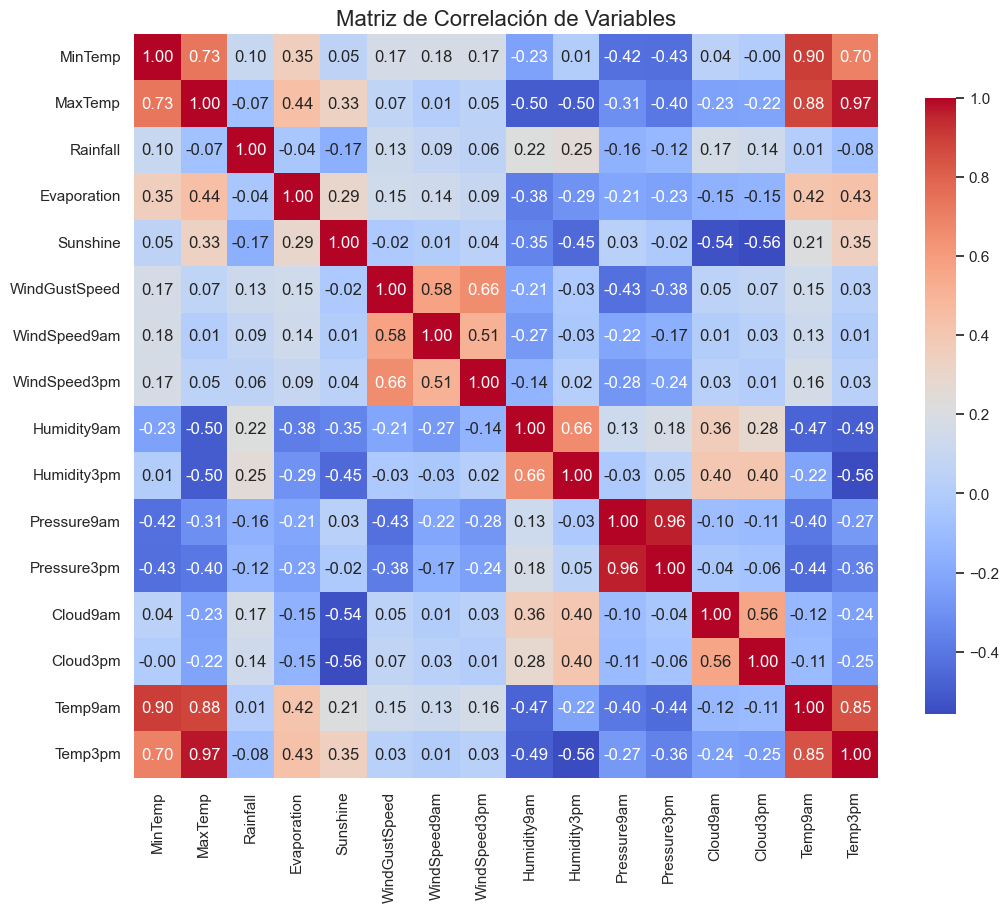

In [25]:

# Eliminar columnas no numéricas
df_numeric = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Crear un mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Configurar el título
plt.title('Matriz de Correlación de Variables', fontsize=16)
plt.show()

In [26]:
# Eliminar columnas no numéricas
X_train_numeric = X_train.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = X_train_numeric.corr()

# Aplanar la matriz de correlación y resetear los índices
correlation_pairs = correlation_matrix.unstack().reset_index()

# Renombrar las columnas
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Eliminar las correlaciones duplicadas (diagonal y columnas)
correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]

# Ordenar por la mayor correlación positiva
correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Eliminar duplicados y valores nulos
correlation_pairs.drop_duplicates(subset=['Correlation'], inplace=True)
correlation_pairs.dropna(inplace=True)

# Resetear el índice
correlation_pairs.reset_index(drop=True, inplace=True)

# Mostrar las 10 pares de variables con mayor correlación positiva y las 10 pares de variables con mayor correlación negativa
print(correlation_pairs.head(10), '\n', correlation_pairs.tail(10))

      Variable 1     Variable 2  Correlation
0        MaxTemp        Temp3pm     0.984679
1    Pressure9am    Pressure3pm     0.961432
2        Temp9am        MinTemp     0.902003
3        MaxTemp        Temp9am     0.887254
4        Temp9am        Temp3pm     0.861000
5        MaxTemp        MinTemp     0.737161
6        Temp3pm        MinTemp     0.709838
7  WindGustSpeed   WindSpeed3pm     0.686251
8    Humidity9am    Humidity3pm     0.667689
9   WindSpeed9am  WindGustSpeed     0.606292 
       Variable 1   Variable 2  Correlation
110  Humidity9am      Temp9am    -0.471252
111     Sunshine  Humidity9am    -0.489356
112      Temp3pm  Humidity9am    -0.498119
113  Humidity9am  Evaporation    -0.502318
114      MaxTemp  Humidity9am    -0.503831
115  Humidity3pm      MaxTemp    -0.508502
116      Temp3pm  Humidity3pm    -0.556868
117     Sunshine  Humidity3pm    -0.628780
118     Cloud9am     Sunshine    -0.674649
119     Sunshine     Cloud3pm    -0.704473


## Estandarizacion y escalado de datos ##

Gracias a los boxplots hechos anteriormente, podemos ver una cantidad de valores atipicos grande, entonces lo que mas nos conviene es usar un escalado robusto

In [27]:
# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Inicializar el escalador robusto
scaler = RobustScaler()

# Aplicar el escalador robusto a las columnas numéricas
df_scaled = df.copy()  # Hacer una copia del DataFrame original
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Mostrar las primeras filas del DataFrame escalado
print(df_scaled.head())

         Date Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury  0.152174  0.019417  1.000000          0.0       0.0   
1  2008-12-02   Albury -0.500000  0.233010  0.000000          0.0       0.0   
2  2008-12-03   Albury  0.097826  0.291262  0.000000          0.0       0.0   
3  2008-12-04   Albury -0.304348  0.514563  0.000000          0.0       0.0   
4  2008-12-05   Albury  0.597826  0.932039  1.666667          0.0       0.0   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W       0.333333          W  ...    0.038462    -1.054968   
1         WNW       0.333333        NNW  ...   -1.000000    -0.947826   
2         WSW       0.466667          W  ...   -1.230769    -0.769254   
3          NE      -1.000000         SE  ...   -0.961538    -1.269254   
4           W       0.133333        ENE  ...    0.461538    -0.662111   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0    -1.198788 